# Problema de Ant Colony Optimization

Código tomado de [Ant Colony Optimization](https://github.com/johnberroa/Ant-Colony-Optimization/blob/master/AntColonyOptimizer.py). Todos los créditos son de [Jerzy Pawlikowski](https://github.com/jerzypawlikowski).

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import time

import warnings

warnings.filterwarnings("ignore")


class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0, beta_evaporation_rate=0,
                 choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_evaporation_rate: rate at which beta decays (optional)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\nNumber of ants:\t\t\t\t{}".format(self.ants)
        string += "\nEvaporation rate:\t\t\t{}".format(self.evaporation_rate)
        string += "\nIntensification factor:\t\t{}".format(self.pheromone_intensification)
        string += "\nAlpha Heuristic:\t\t\t{}".format(self.heuristic_alpha)
        string += "\nBeta Heuristic:\t\t\t\t{}".format(self.heuristic_beta)
        string += "\nBeta Evaporation Rate:\t\t{}".format(self.beta_evaporation_rate)
        string += "\nChoose Best Percentage:\t\t{}".format(self.choose_best)
        string += "\n--------------------"
        string += "\nUSAGE:"
        string += "\nNumber of ants influences how many paths are explored each iteration."
        string += "\nThe alpha and beta heuristics affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\nBeta evaporation reduces the influence of the heuristic over time."
        string += "\nChoose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[np.random.randint(0, len(self.set_of_available_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                              "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")

    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.evaporation_rate, self.pheromone_intensification, self.heuristic_alpha,
                        self.heuristic_beta, self.beta_evaporation_rate, self.choose_best, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best, 2)))
            plt.show()

###Primero tomaremos en cuenta solo las coordenas para entender como se está comportando nuestro ejercicio. Luego con esta información pasaremos a analizar el modelo, pero con los parametros que definimos para el costo del viaje.

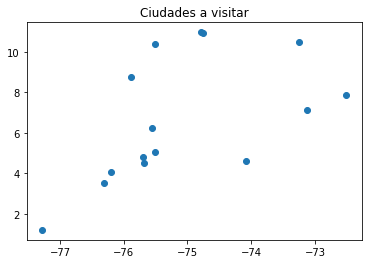

In [91]:
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

# Cities coordinates
Ciudades = pd.DataFrame({'long':[-76.30361, -77.28111, -76.19536, -74.08175, -75.69611, -75.68111, -75.51738, -73.25322, -75.88143, -74.76459, -75.51444, -74.78132, -75.56359, -73.1198, -72.50782],
                           'lat':[3.53944, 1.21361, 4.08466, 4.60971, 4.81333, 4.53389, 5.06889, 10.46314, 8.74798, 10.91843, 10.39972, 10.96854, 6.25184, 7.12539, 7.89391]})

# Cities
x = Ciudades['long']
y = Ciudades['lat']

# Set up the figure
plt.scatter(x, y)
plt.title("Ciudades a visitar")
plt.show()

#print(Ciudades)


In [92]:
M = distance_matrix(Ciudades,Ciudades)
problem = M


Beginning ACO Optimization with 40 iterations...
Best score at iteration 0: 34.66; overall: 34.66 (0s)
Best score at iteration 1: 36.92; overall: 34.66 (0s)
Best score at iteration 2: 32.07; overall: 32.07 (0s)
Best score at iteration 3: 35.53; overall: 32.07 (0s)
Best score at iteration 4: 26.81; overall: 26.81 (0s)
Best score at iteration 5: 31.74; overall: 26.81 (0s)
Best score at iteration 6: 30.55; overall: 26.81 (0s)
Best score at iteration 7: 26.38; overall: 26.38 (0s)
Best score at iteration 8: 32.03; overall: 26.38 (0s)
Best score at iteration 9: 23.86; overall: 23.86 (0s)
Best score at iteration 10: 26.05; overall: 23.86 (0s)
Best score at iteration 11: 26.05; overall: 23.86 (0s)
Best score at iteration 12: 26.75; overall: 23.86 (0s)
Best score at iteration 13: 26.08; overall: 23.86 (0s)
Best score at iteration 14: 26.05; overall: 23.86 (0s)
Best score at iteration 15: 26.05; overall: 23.86 (0s)
Best score at iteration 16: 25.78; overall: 23.86 (0s)
Best score at iteration 17

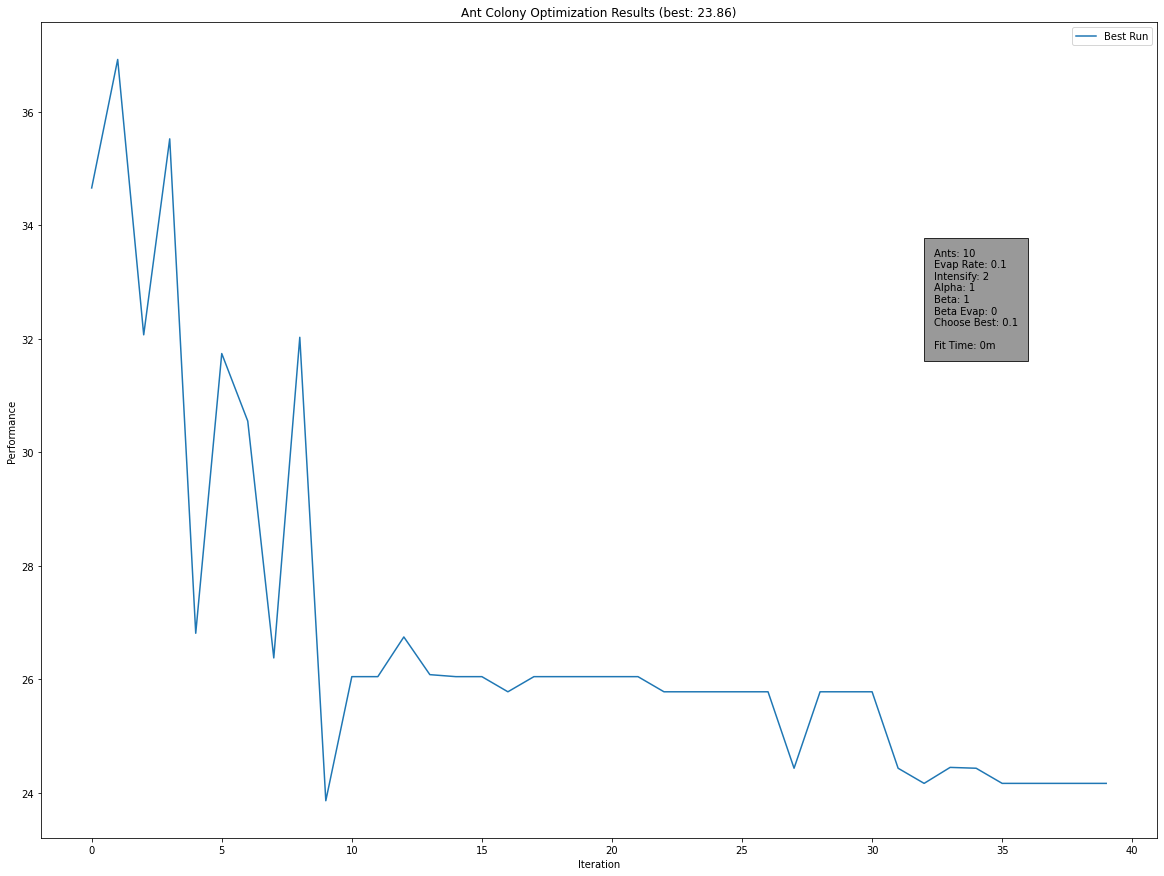

In [93]:
optimizer = AntColonyOptimizer(ants=10, evaporation_rate=.1, intensification=2, alpha=1, beta=1,
                               beta_evaporation_rate=0, choose_best=.1)
best = optimizer.fit(problem, 40) #Se hace hasta 40 porque desde 30 ya tiende a estabilizarse

optimizer.plot()

In [94]:
optimizer.best_path

[14, 7, 9, 11, 10, 8, 12, 6, 4, 2, 0, 1, 5, 3, 13, 14]

####Se busca confirmar y mostrar cual sería la mejor ruta solo considerando las coordenadas.

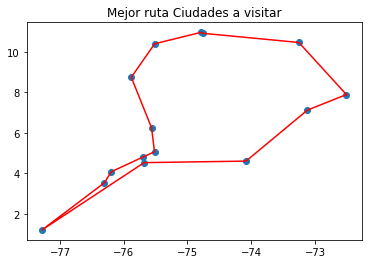

In [95]:
import numpy as np

# Convertir Ciudades a matriz NumPy
Ciudades_np = Ciudades.to_numpy()

# Obtener la mejor ruta
best_path = optimizer.best_path

# Plotear la mejor ruta
plt.scatter(x, y)
plt.plot(Ciudades_np[best_path, 0], Ciudades_np[best_path, 1], '-r')
plt.title("Mejor ruta Ciudades a visitar")
plt.show()


##Conociendo mejor como se comportan los datos pasamos a cargar lo que definimos como costo de viaje.
Necesario cargar el archivo adjunto que contiene los datos de costos

In [96]:
import io
from google.colab import files
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.spatial import distance_matrix

#uploaded = files.upload()
#costMatrix = pd.read_csv(io.BytesIO(uploaded['Costos_total.csv']))

data = pd.read_excel('Costos_total.xlsx') 

M=data.to_numpy()


Beginning ACO Optimization with 5 iterations...
Best score at iteration 0: 2187582.45; overall: 2187582.45 (0s)
Best score at iteration 1: 2170070.15; overall: 2170070.15 (0s)
Best score at iteration 2: 2004975.49; overall: 2004975.49 (0s)
Best score at iteration 3: 1935915.66; overall: 1935915.66 (0s)
Best score at iteration 4: 1727728.0; overall: 1727728.0 (0s)
ACO fitted.  Runtime: 0 minutes.  Best score: 1727728.0046511628
Beginning ACO Optimization with 10 iterations...
Best score at iteration 0: 2247473.28; overall: 2247473.28 (0s)
Best score at iteration 1: 2253944.33; overall: 2247473.28 (0s)
Best score at iteration 2: 2120070.73; overall: 2120070.73 (0s)
Best score at iteration 3: 2027804.89; overall: 2027804.89 (0s)
Best score at iteration 4: 1735078.63; overall: 1735078.63 (0s)
Best score at iteration 5: 1899874.12; overall: 1735078.63 (0s)
Best score at iteration 6: 1735078.63; overall: 1735078.63 (0s)
Best score at iteration 7: 1735078.63; overall: 1735078.63 (0s)
Best sco

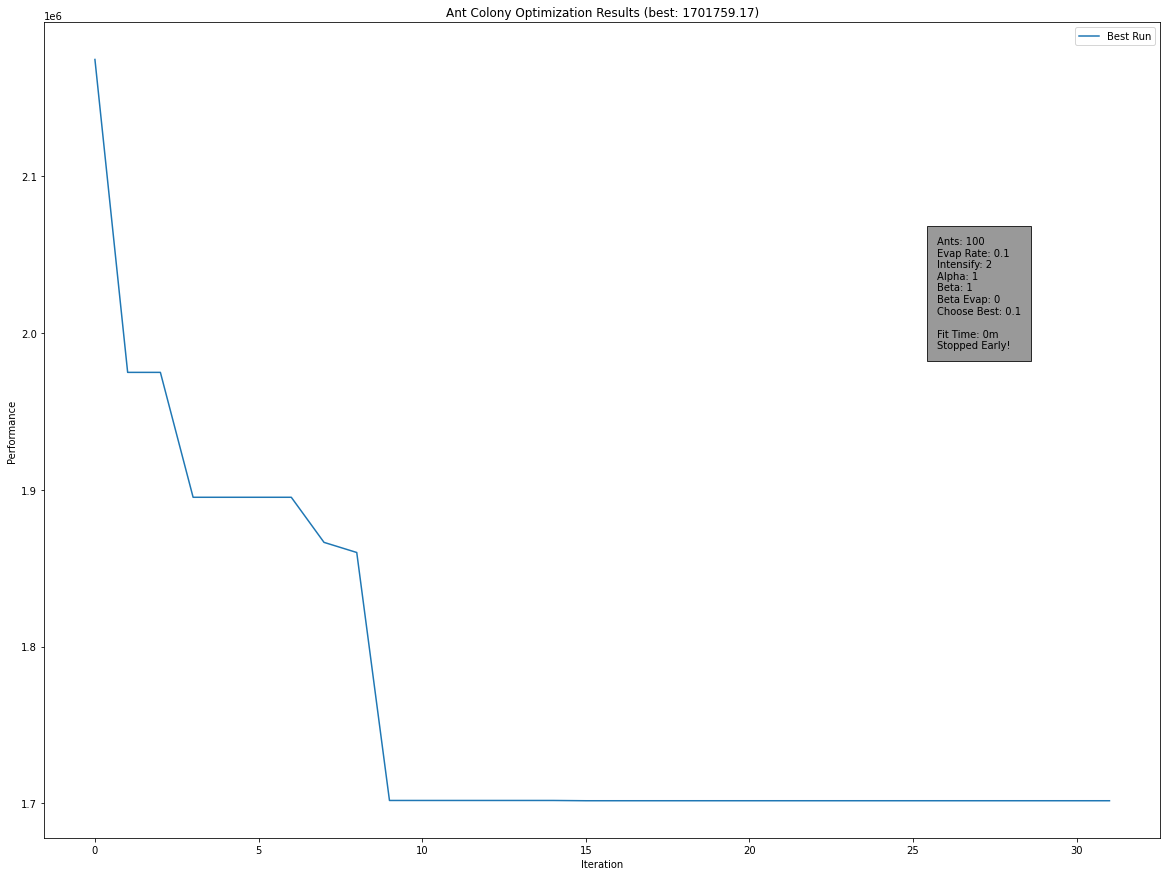

In [97]:
best_pa = pd.DataFrame(columns = ['iter1','iter2', 'iter3', 'iter4', 'iter5', 'iter6', 'iter7', 'iter8', 'iter9', 'iter10'])
#Iter = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
Iter = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
#Iter = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] #con este tambien funciona
for n in range(10):

    # Create the Antiptimizer using differents parameteres
    optimizer = AntColonyOptimizer(ants=100, evaporation_rate=.1, intensification=2, alpha=1, beta=1,
                                   beta_evaporation_rate=0, choose_best=.1)
    optimizer.fit(M,Iter[n])
    
    # Save the values in a dataframe
    best_pa[best_pa.columns[n]] = optimizer.best_path
    #optimizer.plot()
#print(best_pa) #best_pa tienen las iteraciones, para graficar con eso el GIF
optimizer.plot()
#Se varia el numero de ant=100 con respecto al anterior que era 10 para que así se pueda tener una 
#mejor aproximacion porque para nuestro caso no son coordenadas si no numeros más grandes.

In [98]:
best_pa_np=best_pa.to_numpy()
#best_pa_np #Solo mostrar la matriz pero para la entrega no es necesario

###Aqui se muestra el GIF con las iteraciones, en caso de estar en Colab se le creara un archivo.gif que le permitirá su reproducción. Este será guardado coo ruta_1.gif

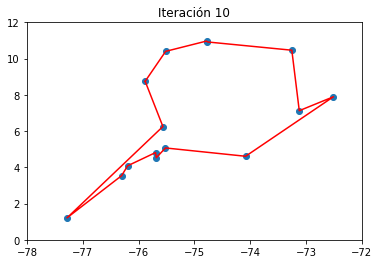

In [99]:
import imageio

# Crear una lista vacía para guardar cada imagen
images = []

# Crear una figura y un eje para la gráfica
fig, ax = plt.subplots()
# Iterar a través de todas las iteraciones
for i in range(best_pa_np.shape[1]):
    #Borra en cada iteracion
    ax.clear()
    # Crear la gráfica para la iteración actual
    ax.scatter(x, y)
    ax.plot(Ciudades_np[best_pa_np[:, i], 0], Ciudades_np[best_pa_np[:, i], 1], '-r')
    ax.set_title(f"Iteración {i+1}")
    ax.set_xlim([-78, -72])
    ax.set_ylim([0, 12])
    
    # Guardar la figura actual como una imagen en la lista
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
    

# Guardar la lista de imágenes como un GIF
imageio.mimsave('ruta_1.gif', images, duration=0.5)


Con este GIF se puede confirmar las posible rutas que podría tomar el viajero.Como confirmamos con la de coordenadas la decima iteración da el mejor resultado, aunque varia el recorrido entre ciudades como pasto y bogota, sabemos que esto se debe a los parametros que consideramos para el precio del viaje entre ciudades y entendemos que se muestre esto dado que en algunas ciudades aunque esten a la misma distancia dependiendo de la ciudad donde se encuentre el precio del peaje puede variar y esta es una de las variables más influyentes en nuestro modelo. Es por esto que consideramos que nuestro modelo funciona, ya que no solo da la mejor ruta, si nno tambien la que minimice los costos.

###A Continuación se quería confirmar que cada uno de las coordenas estuvieran donde deben estar, por lo que se grafican utilizando scatter_geo, en caso de no tener una buena visualización hacer zoom.

In [87]:
import plotly.express as px
import pandas as pd

# Crear el DataFrame de ciudades con coordenadas y nombres
Ciudades_l = pd.DataFrame({
    'nombre': ['Palmira', 'Pasto', 'Tuluá', 'Bogota', 'Pereira', 'Armenia', 'Manizales', 'Valledupar', 'Montería', 'Soledad', 'Cartagena', 'Barranquilla', 'Medellín', 'Bucaramanga', 'Cúcuta'],
    'long':[-76.30361, -77.28111, -76.19536, -74.08175, -75.69611, -75.68111, -75.51738, -73.25322, -75.88143, -74.76459, -75.51444, -74.78132, -75.56359, -73.1198, -72.50782],
    'lat':[3.53944, 1.21361, 4.08466, 4.60971, 4.81333, 4.53389, 5.06889, 10.46314, 8.74798, 10.91843, 10.39972, 10.96854, 6.25184, 7.12539, 7.89391]
})

# Graficar el mapa de Colombia con nombres de ciudades
fig = px.scatter_geo(Ciudades_l, lat='lat', lon='long', text='nombre')
fig.update_geos(projection_type="natural earth", showcountries=True, countrycolor="gray")
fig.show()


###Aqui se muestra cada una de las iteraciones, si se le da click a alguna se pueden apreciar por separado.

In [88]:
import plotly.graph_objects as go

# Crear una figura para el mapa
fig = go.Figure()
image=[]

# Agregar la capa del mapa de Colombia
fig.add_trace(go.Scattergeo(
        lon=Ciudades_l['long'],
        lat=Ciudades_l['lat'],
        mode='text',
        text=Ciudades_l['nombre'], # Agrega el nombre de la ciudad como texto
        
    )
)

# Agregar cada una de las rutas
for i in range(best_pa_np.shape[1]):
    fig.add_trace(go.Scattergeo(
        lon=Ciudades_np[best_pa_np[:, i], 0],
        lat=Ciudades_np[best_pa_np[:, i], 1],
        mode='lines',
        line=dict(
            width=1,
            color='blue'
        ),
        opacity=0.7
    )
    
    )

    


# Configurar el layout de la figura
fig.update_geos(
    projection_type="natural earth",
    showcountries=True,
    countrycolor="gray"
)

# Mostrar la figura
fig.show()

###Para poder apreciar el GIF final es necesario adjuntar la imagen png y este será guardado como ruta.gif

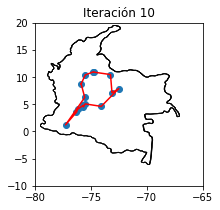

In [100]:
import imageio
from PIL import Image

# Cargar la imagen del mapa de Colombia y redimensionarla a las dimensiones de las iteraciones
mapa = Image.open("colombia.png").resize((140, 140))

# Crear una lista vacía para guardar cada imagen
images = []

# Crear una figura y un eje para la gráfica
fig, ax = plt.subplots(figsize=(3,3))

# Iterar a través de todas las iteraciones
for i in range(best_pa_np.shape[1]):
    #Borra en cada iteracion
    ax.clear()
    
    # Agregar el mapa de Colombia como fondo
    fig.figimage(mapa, xo=40, yo=45, alpha=0.5)
    
    # Crear la gráfica para la iteración actual
    ax.scatter(x, y)
    ax.plot(Ciudades_np[best_pa_np[:, i], 0], Ciudades_np[best_pa_np[:, i], 1], '-r')
    ax.set_title(f"Iteración {i+1}")
    ax.set_xlim([-80, -65])
    ax.set_ylim([-10, 20])
    
    # Guardar la figura actual como una imagen en la lista
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
    

# Guardar la lista de imágenes como un GIF
imageio.mimsave('ruta.gif', images, duration=0.5)
